In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/pytorch_faster_rcnn

/content/drive/My Drive/pytorch_faster_rcnn


In [4]:
!pip install torch==1.5.1
!pip install torchvision==0.5.0

     |████████████████████████████████| 753.2MB 22kB/s 
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [5]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uqrsna3r
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uqrsna3r
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=8038d4827c1f2cd9efd428405d2e6e79ceed971559f9b798389384e172763175
  Stored in directory: /tmp/pip-ephem-wheel-cache-ubjbbdc4/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


In [9]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 9252, done.
remote: Total 9252 (delta 0), reused 0 (delta 0), pack-reused 9252
Receiving objects: 100% (9252/9252), 11.21 MiB | 6.20 MiB/s, done.
Resolving deltas: 100% (6418/6418), done.
Checking out files: 100% (425/425), done.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensor
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,Compose, GaussNoise)
import glob
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# import cv2
# all_txt =  glob.glob("txt/*.txt")
# areas = []
# bboxs = []
# dem=0
# heights = []
# widths = []
# img_ids = []
# for x in all_txt:
#   path_img = "valid/"+x.split("/")[-1].split(".")[0]+".jpg"
#   img = cv2.imread(path_img)
#   if img is None:
#     continue
#   f = open(x,"r")
#   a = f.readlines()[0]
#   bbox = [float(value) for value in a.split(" ")]

#   w_real = int(bbox[3]*img.shape[1]/2)
#   h_real = int(bbox[4]*img.shape[0]/2)

#   x_top = int(bbox[1]*img.shape[1])-w_real
#   y_top = int(bbox[2]*img.shape[0])-h_real
#   x_bot = int(bbox[1]*img.shape[1])+w_real
#   y_bot = int(bbox[2]*img.shape[0])+h_real

#   img_ids.append(x.split("/")[-1].split(".")[0]+".jpg")
#   widths.append(img.shape[1])
#   heights.append(img.shape[0])

#   areas.append((x_top-y_top)*(x_bot-y_bot))
#   bboxs.append([x_top,y_top,x_bot,y_bot])
#   dem+=1
#   print(dem)
#   f.close()

In [47]:
# import pandas as pd
# csv = pd.DataFrame({
#     'image_id':img_ids,
#     'width':widths,
#     'height':heights,
#     'bbox':bboxs,
#     'areas':areas
# })
# csv.to_csv("valid.csv",index=False)

In [51]:
# train_dir = 'train'
# valid_dir = 'valid'
# test_dir = 'test'
# bounding_box = 'bbox.csv'
# valid_bbox = 'valid.csv'

In [ ]:
# df_train = pd.read_csv(bounding_box)
# df_train.head()

In [ ]:
# df_valid = pd.read_csv(valid_bbox)
# df_valid.head()

In [13]:
# this function will take the dataframe and vertically stack the image ids 
# with no bounding boxes
def process_bbox(df):
    df['bbox'] = df['bbox'].apply(lambda x: eval(str(x)))
    df['x'] = df['bbox'].apply(lambda x: x[0])
    df['y'] = df['bbox'].apply(lambda x: x[1])
    df['w'] = df['bbox'].apply(lambda x: x[2])
    df['h'] = df['bbox'].apply(lambda x: x[3])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)
    df['image_id'] = df['image_id'].apply(lambda x:x.split(".")[0]) 
    df.drop(columns=['bbox'],inplace=True)
#     df.reset_index(drop=True)
    return df

In [54]:
df_train = process_bbox(df_train)
df_valid = process_bbox(df_valid)
df_new = pd.concat([df_train,df_valid])

In [56]:
df_new.shape

(6443, 8)

In [57]:
# Preparation data
data_train = os.listdir(train_dir)
train_ids = list()
for i in range(0,len(os.listdir(train_dir))):
  k = os.path.splitext(data_train[i])
  train_ids.append(k[0])
print ('Number of train image is: ', len(os.listdir(train_dir)))

data_valid = os.listdir(valid_dir)
valid_ids = list()
for i in range(0,len(os.listdir(valid_dir))):
  k = os.path.splitext(data_valid[i])
  valid_ids.append(k[0])
print ('Number of validation image is: ', len(os.listdir(valid_dir)))

data_test = os.listdir(test_dir)
test_ids = list()
for i in range(0,len(os.listdir(test_dir))):
  k = os.path.splitext(data_test[i])
  test_ids.append(k[0])
print ('Number of test image is: ', len(os.listdir(test_dir)))

Number of train image is:  5276
Number of validation image is:  1319
Number of test image is:  48


In [59]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(valid_ids)]
# test_df = df_new[df_new['image_id'].isin(test_ids)]

print ("Train: ",train_df.shape)
print ("Validation: ",val_df.shape)
# print ("Test: ",test_df.shape)

Train:  (5125, 8)
Validation:  (1318, 8)


In [60]:
def get_transforms(phase):
  list_transforms = []
  if phase == 'train':
    list_transforms.extend([Flip(p=0.5)])
  list_transforms.extend([ToTensor(),])
  list_trfms = Compose(list_transforms,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  return list_trfms

In [61]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        # boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        # boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target

In [62]:
train_data = Wheatset(train_df,train_dir,phase='train')
val_data = Wheatset(val_df,valid_dir,phase='validation')
# test_data = Wheatset(test_df,test_dir,phase='test')

In [63]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.4745, 0.4627, 0.4588],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.4745, 0.4784],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.4706, 0.4824],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.7412, 0.7490, 0.8157],
          [0.0000, 0.0000, 0.0000,  ..., 0.7412, 0.7490, 0.8196],
          [0.0000, 0.0000, 0.0000,  ..., 0.7373, 0.7490, 0.8235]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.4745, 0.4627, 0.4588],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.4745, 0.4784],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.4706, 0.4824],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.7412, 0.7490, 0.8157],
          [0.0000, 0.0000, 0.0000,  ..., 0.7412, 0.7490, 0.8196],
          [0.0000, 0.0000, 0.0000,  ..., 0.7373, 0.7490, 0.8235]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.4745, 0.4627, 0.4588],
          [0.0000, 0.0000, 0.0000,  ..., 0.4627, 0.4745, 0.4784],
          [0.0000, 0.0000, 0.0000,  ...,

In [64]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

In [65]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

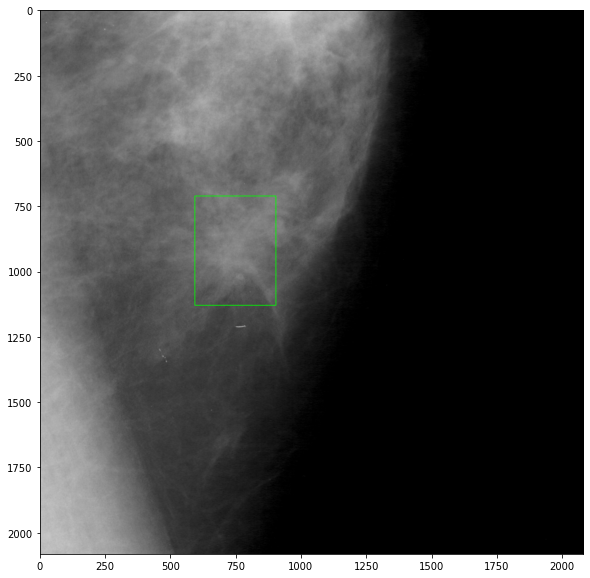

In [66]:
plot_img(train_data,21)

In [67]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

train_loss=[]
total_train_loss = []
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    return metric_logger

In [68]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [69]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from engine import evaluate
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer,train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the valid dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [  0/641]  eta: 1:10:33  lr: 0.000013  loss: 0.6891 (0.6891)  loss_classifier: 0.5402 (0.5402)  loss_box_reg: 0.0080 (0.0080)  loss_objectness: 0.1350 (0.1350)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 6.6050  data: 2.3645  max mem: 8668
Epoch: [0]  [ 10/641]  eta: 0:41:08  lr: 0.000091  loss: 0.7011 (0.7032)  loss_classifier: 0.4886 (0.4515)  loss_box_reg: 0.0080 (0.0084)  loss_objectness: 0.2092 (0.2326)  loss_rpn_box_reg: 0.0099 (0.0107)  time: 3.9115  data: 0.2922  max mem: 8668
Epoch: [0]  [ 20/641]  eta: 0:39:19  lr: 0.000169  loss: 0.4320 (0.5195)  loss_classifier: 0.2134 (0.3004)  loss_box_reg: 0.0154 (0.0185)  loss_objectness: 0.1424 (0.1902)  loss_rpn_box_reg: 0.0100 (0.0103)  time: 3.6589  data: 0.0847  max mem: 8668
Epoch: [0]  [ 30/641]  eta: 0:38:20  lr: 0.000247  loss: 0.2799 (0.4364)  loss_classifier: 0.1051 (0.2378)  loss_box_reg: 0.0374 (0.0310)  loss_objectness: 0.1062 (0.1580)  loss_rpn_box_reg: 0.0079 (0.0096)  time: 3.6845  data: 0.0875  max mem: 8668


In [ ]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
evaluate(model, test_data_loader, device=device)

In [ ]:
images, targets = next(iter(test_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
for i in range(0,8):
  boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
  sample = images[i].permute(1,2,0).cpu().numpy()
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  print ("Total bounding box of image: ",len(boxes))
  for box in boxes:
      cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 255, 0), 3)

  ax.set_axis_off()
  ax.imshow(sample)

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
for i in range(0,8):
  detection_threshold = 0.7
  sample_ = images[i].permute(1,2,0).cpu().numpy()
  boxes_ = outputs[i]['boxes'].data.cpu().numpy()
  scores_ = outputs[i]['scores'].data.cpu().numpy()

  boxes_ = boxes_[scores_ >= detection_threshold].astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  print ("Total bounding box of image (predict): ",len(boxes_))
  for box in boxes_:
      # print('bounding box: ',box[0],' ',box[1],' ',box[2],' ',box[3])
      cv2.rectangle(sample_,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 255, 0), 3)

  ax.set_axis_off()
  ax.imshow(sample_)